## Donut 🍩, Document understanding transformer

![model image](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/donut_architecture.jpg)

[paper: OCR-free Document Understanding Transformer](https://huggingface.co/papers/2111.15664)

[clovaai/donut Github](https://github.com/clovaai/donut?tab=readme-ov-file)

[donut-base model on huggingface](https://huggingface.co/naver-clova-ix/donut-base/)


### TEXT FORMAT

**during training:**

- **INPUT:**
  - Image embedding
  - task_start_token + bos_token + json2token(ground_truth_json) + eos_token

**during inference:**

- **INPUT:**
  - Image embedding
  - task_start_token

- **OUTPUT:**
  - ground_truth_json

In [ ]:
!pip show transformers

Name: transformers
Version: 4.56.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [1]:
!git clone https://github.com/hftuner/clovaai-donut.git /content/hftuner

Cloning into '/content/hftuner'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 0), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 4.16 KiB | 4.16 MiB/s, done.


In [ ]:
import os
import json
from datasets import load_dataset

dataset = load_dataset('hf-tuner/SROIE-document-parsing')


In [3]:
ignore_id = -100
task_start_token = "<parsing>"
new_special_tokens = []

new_special_tokens.extend([task_start_token])


In [ ]:
from hftuner.donut import DataProcessor

data_processor = DataProcessor()
json2token = data_processor.json2token

example_doc_parsing_gt ={
    "menu": [
      {
        "nm": "[MD] SOFT STEAMED CHEESEC",
        "cnt": "2",
        "price": "20,000"
      },
      {
        "nm": "[MD] SOFT STEAMED CHOCOCA",
        "cnt": "2",
        "price": "20,000"
      }
    ],
    "total": {
      "total_price": "40,000",
      "cashprice": "100,000",
      "changeprice": "60,000"
    }
  } #gt_parse

json2token(example_doc_parsing_gt)

'<s_total><s_total_price>40,000</s_total_price><s_changeprice>60,000</s_changeprice><s_cashprice>100,000</s_cashprice></s_total><s_menu><s_price>20,000</s_price><s_nm>[MD] SOFT STEAMED CHEESEC</s_nm><s_cnt>2</s_cnt><sep/><s_price>20,000</s_price><s_nm>[MD] SOFT STEAMED CHOCOCA</s_nm><s_cnt>2</s_cnt></s_menu>'

## special tokens from dataset

In [ ]:
def clean_docs_for_donut(sample):
    gt = json.loads(sample["ground_truth"])
    parsed_text = gt['gt_parse'] if 'gt_parse' in gt else gt['gt_parses']
    text = json2token(parsed_text, update_special_tokens_for_json_key=True) # adds a new token for each key
    return {"text": text}

columns_to_remove = [ c for c in dataset['train'].column_names if c not in ['image', 'ground_truth', 'text']]

data_processor.clear_new_special_tokens()
proc_dataset = dataset.map(clean_docs_for_donut, remove_columns=columns_to_remove)
new_key_tokens = data_processor.get_new_special_tokens()

print(f"Sample:\n{proc_dataset['train'][4]['text']}")
# bos_token and eos_token will be added by data collator function

Map:   0%|          | 0/875 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Sample:
<s_total>174.90</s_total><s_date>03/03/2018</s_date><s_company>three stooges</s_company><s_address>109, ss21/1a, damansara utama</s_address>


## load model and processor

In [6]:
import torch
from transformers import DonutProcessor, VisionEncoderDecoderConfig
from hftuner.donut import DonutModel

ckpt = 'naver-clova-ix/donut-base'
processor = DonutProcessor.from_pretrained(ckpt)
model = DonutModel.from_pretrained(ckpt)

len(processor.tokenizer)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

57525

### Configure processor and model for finetuning

In [ ]:
new_special_tokens = list(set(new_special_tokens + new_key_tokens))
print(f"New special tokens:  {new_special_tokens}")

# add new special tokens to tokenizer
print(f"Adding {len(new_special_tokens)} special tokens")
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens})

# https://x.com/karpathy/status/1621578354024677377?lang=en
multiplier = 64
if len(processor.tokenizer) % multiplier != 0:
  extra_token_count = multiplier - (len(processor.tokenizer) % multiplier)
  print(f"Adding {extra_token_count} fake tokens")
  fake_tokens = [f"<reserved_{i+1}>" for i in range(extra_token_count)]
  processor.tokenizer.add_tokens(fake_tokens)

print(f"New tokenizer length: {len(processor.tokenizer)}")

New special tokens:  ['<parsing>', '<s_date>', '</s_date>', '</s_address>', '<s_total>', '</s_total>', '<s_address>', '<s_company>', '</s_company>']
Adding 9 special tokens
Adding 2 fake tokens
New tokenizer length: 57536


In [8]:
# to find max_token to output during training
def add_token_count(example):
  example['tokens_count'] = processor.tokenizer(
      example['text'],
      add_special_tokens=True,
      return_tensors="pt",
  ).input_ids[0].shape[0]
  return example

proc_dataset = proc_dataset.map(add_token_count)
max_length = max(proc_dataset['train']['tokens_count'])
print('maximum length of example:', max_length)



Map:   0%|          | 0/875 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

maximum length of example: 89


In [9]:
max_length = 128
processor_image_size = [720, 960] # (width, height)

## UPDATE: processor
processor.image_processor.size['width'] = processor_image_size[0]
processor.image_processor.size['height'] = processor_image_size[1]
processor.image_processor.do_align_long_axis = False # don't rotate image if height is greater than width

## UPDATE: model

# generation config
model.config.decoder.max_length = max_length
model.config.pad_token_id = processor.tokenizer.pad_token_id
# ⚠️ IMPORTANT: set decoder_start_token
task_token_id = processor.tokenizer.encode(task_start_token, add_special_tokens=False)[0]
task_token_id
model.config.decoder_start_token_id = task_token_id

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))

# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor_image_size[::-1] # (height, width)

print(f"New token embedding size: {new_emb}")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


New token embedding size: MBartScaledWordEmbedding(57536, 1024, padding_idx=1)


More about : [decoder_start_token_id](https://github.com/huggingface/transformers/blob/4df2529d79d75f44e70396df5888a32ffa02d61e/src/transformers/models/vision_encoder_decoder/modeling_vision_encoder_decoder.py#L331)

## Data Collator

In [10]:
def prepare_data(examples):
    images = [e['image'].convert("RGB") for e in examples]
    texts = [e['text'] for e in examples]
    # create tensor from image
    pixel_values = processor(
        images,
        return_tensors="pt"
        ).pixel_values
    # tokenize text
    input_ids = processor.tokenizer(
        texts,
        add_special_tokens=True, # add <s> and </s>
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    ).input_ids
    labels = input_ids.clone()
    # ignore pad tokens when calculating `loss`
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id
    return {"pixel_values": pixel_values, "labels": labels}

# TEST
batch= prepare_data([
    proc_dataset['train'][5],
])
batch.keys(), batch['pixel_values'].shape, batch['labels'].shape

(dict_keys(['pixel_values', 'labels']),
 torch.Size([1, 3, 600, 400]),
 torch.Size([1, 128]))

## ⚙️ Train

In [11]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

save_model_name = "donut-base-finetuned-sroie"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=save_model_name,
    num_train_epochs=3,
    max_steps = 100,
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size =1,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    eval_strategy="no",
    save_strategy="epoch",
    save_total_limit=1,
    # group_by_length=True,
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=save_model_name,
    remove_unused_columns=False
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=prepare_data,
    train_dataset=proc_dataset["train"],
    # eval_dataset=proc_dataset["test"],
)


In [12]:
# Start training
trainer.train()

Step,Training Loss
100,6.710700


TrainOutput(global_step=100, training_loss=6.710670776367188, metrics={'train_runtime': 46.1335, 'train_samples_per_second': 2.168, 'train_steps_per_second': 2.168, 'total_flos': 6.1072493184e+16, 'train_loss': 6.710670776367188, 'epoch': 0.11428571428571428})

In [ ]:
trainer.save_model(save_model_name)
processor.save_pretrained(save_model_name)

# Save processor and create model card
hf_repo_id = f"hf-tuner/{save_model_name}"
trainer.create_model_card()
trainer.push_to_hub()
processor.push_to_hub(repo_id=hf_repo_id)


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...e-finetuned-sroie/training_args.bin: 100%|##########| 5.97kB / 5.97kB            

  ...vents.1758526596.2d45ccafa1ee.246.0: 100%|##########| 8.34kB / 8.34kB            

  ...e-finetuned-sroie/model.safetensors:   3%|3         | 25.2MB /  809MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...e-finetuned-sroie/training_args.bin: 100%|##########| 5.97kB / 5.97kB            

  ...vents.1758526596.2d45ccafa1ee.246.0: 100%|##########| 8.34kB / 8.34kB            

  ...e-finetuned-sroie/model.safetensors:   4%|4         | 33.5MB /  809MB            

  ...tuned-sroie/sentencepiece.bpe.model: 100%|##########| 1.30MB / 1.30MB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...tuned-sroie/sentencepiece.bpe.model: 100%|##########| 1.30MB / 1.30MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/hf-tuner/donut-base-finetuned-sroie/commit/0d58ca32ce8ba80c9dc13695a2f7eed251219f35', commit_message='Upload processor', commit_description='', oid='0d58ca32ce8ba80c9dc13695a2f7eed251219f35', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hf-tuner/donut-base-finetuned-sroie', endpoint='https://huggingface.co', repo_type='model', repo_id='hf-tuner/donut-base-finetuned-sroie'), pr_revision=None, pr_num=None)

## 🚀 Inference

In [ ]:
import re
import torch
from transformers import DonutProcessor, VisionEncoderDecoderConfig, VisionEncoderDecoderModel

# ckpt = "/content/donut-base-finetuned-sroie"
ckpt = "hf-tuner/donut-base-finetuned-sroie"

config = VisionEncoderDecoderConfig.from_pretrained(ckpt)
processor = DonutProcessor.from_pretrained(ckpt)
device = "cuda" if torch.cuda.is_available() else "cpu"
config.dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = VisionEncoderDecoderModel.from_pretrained(ckpt, config=config)
model.to(device)


In [ ]:
from datasets import load_dataset

dataset = load_dataset('hf-tuner/SROIE-document-parsing')

In [ ]:
# inference (generation)
sample = dataset['train'][23]

pixel_values = processor(sample['image'],return_tensors="pt").pixel_values.to(device)

task_start_token = "<parsing>"
decoder_input_ids = processor.tokenizer(task_start_token, add_special_tokens=False, return_tensors="pt").input_ids.to(device)

generated_ids = model.generate(pixel_values,
                               decoder_input_ids=decoder_input_ids,
                               max_length=128,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]]
                               )

print(f'generated tokens count: {len(generated_ids[0])}')
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
print(generated_text)
processor.token2json(generated_text)

generated tokens count: 51
<parsing><s><s_total> 62.60</s_total><s_date> 30/10/2017</s_date><s_company> gardenia bakeries (kl) sdn bhd</s_company><s_address> lot 3, jalan pelabur 23/1, 40300 shah alam, selangor.</s_address></s>


{'total': '62.60',
 'date': '30/10/2017',
 'company': 'gardenia bakeries (kl) sdn bhd',
 'address': 'lot 3, jalan pelabur 23/1, 40300 shah alam, selangor.'}

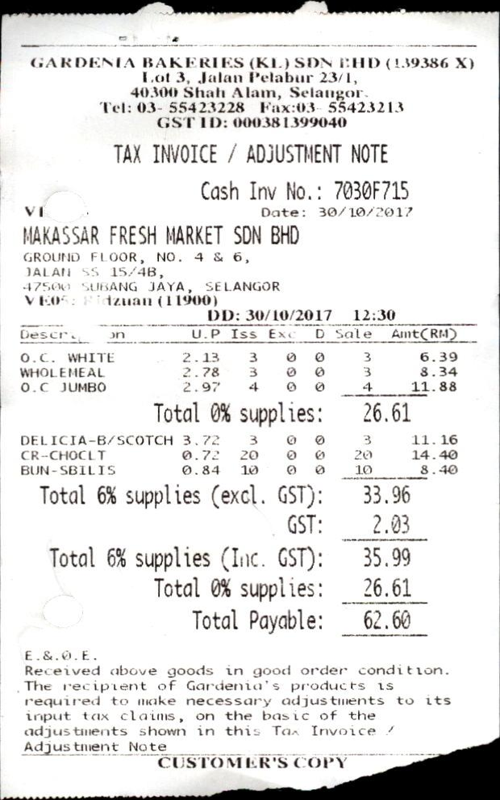

In [ ]:
sample['image'].resize((500,800))